# Statistical Modeling of the Gutenberg–Richter Law in Earthquake Data

### *Introduction*: 
According to the Gutenberg-Richter frequency magnitude relation [1], the number of earthquakes N, having a magnitude equal to or larger than M, can be expressed by the equation  


$$log_{10}(N) = a - b*M$$  

where $a$ is a measure of the level of seismicity and $b$ describes the ration between the number of small and large events. The Gutenberg–Richter relation is of significant importance to seismic studies because it is used to
describe both tectonic and induced seismicity, can be applied
in different time scales, and holds true over a large interval of
earthquake magnitudes.  

This project will analyze the Gutenberg–Richter frequency–magnitude relationship using Balkan (1904–2025) earthquake data, with potential comparison to California and Japan. 



#### *Data preprocessing*

In [13]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import missingno as msn
import numpy as np 
import math 

In [14]:
df = pd.read_csv("data/south_central_balkan.csv")
df.sample(3)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
488,2006-05-14T17:10:07.380Z,41.729,25.538,10.0,2.7,md,15.0,108.9,NaN,1.26,...,2014-11-07T01:29:07.039Z,"16 km ENE of Kardzhali, Bulgaria",earthquake,NaN,NaN,NaN,NaN,reviewed,us,sof
972,2001-06-07T19:00:18.400Z,41.450,20.168,4.8,2.5,md,11.0,NaN,NaN,NaN,...,2014-11-07T01:13:00.469Z,"6 km SW of Bulqizë, Albania",earthquake,NaN,NaN,NaN,NaN,reviewed,pdg,pdg
1959,1990-07-17T13:53:32.500Z,42.535,23.986,10.0,2.6,ml,NaN,NaN,NaN,0.50,...,2014-11-07T00:46:43.600Z,"13 km SSW of Chavdar, Bulgaria",earthquake,NaN,NaN,NaN,NaN,reviewed,us,the


##### *Conversion to common magnitude type* 

Earthquake size, as measured by the Richter Scale is a well known, but not well understood, concept. The idea of a logarithmic earthquake magnitude scale was first developed by Charles Richter in the 1930's for measuring the size of earthquakes occurring in southern California using relatively high-frequency data from nearby seismograph stations. This magnitude scale was referred to as ML, with the L standing for local. This is what was to eventually become known as the Richter magnitude.

As more seismograph stations were installed around the world, it became apparent that the method developed by Richter was strictly valid only for certain frequency and distance ranges. In order to take advantage of the growing number of globally distributed seismograph stations, new magnitude scales that are an extension of Richter's original idea were developed. These include body wave magnitude (Mb) and surface wave magnitude (Ms). Each is valid for a particular frequency range and type of seismic signal. In its range of validity, each is equivalent to the Richter magnitude.

Because of the limitations of all three magnitude scales (ML, Mb, and Ms), a new, more uniformly applicable extension of the magnitude scale, known as moment magnitude, or Mw, was developed. In particular, for very large earthquakes, moment magnitude gives the most reliable estimate of earthquake size.

Since the conversion between ML and MW is somewhat different for each geographical region, we will use the conversion formulas proposed by Neki Kuka et al. [5], where empirical relationships between local and moment magnitues for the Balkan Region are described. In their work, they propose conversion formulas for earthquakes in 6 regions described by their capital cities: Skopje, Tirana, Belgrade, Thessaloniki, Zagreb, and Podgorica, and in this project, the corresponding conversion formula will be applied to earthquakes nearest to the city. 

Furthermore, quakes described with md, ms, mb and other types will be discarded, as they have different sensitivity ranges, yet our methods require describing a reliable "completion threshold" (see below). 

In [15]:

df["magType"].value_counts()

magType
ml      1679
md       847
mb       508
m         58
mw        57
mwr       20
mww       13
mwc       12
ms         2
mblg       1
Name: count, dtype: int64

In [ ]:
df = df[df['magType'].str.lower().isin(['ml', 'mw', 'mwr', 'mww', 'mwc'])].copy()


In [17]:
df["magType"].value_counts()

magType
ml     1679
mw       57
mwr      20
mww      13
mwc      12
Name: count, dtype: int64

In [18]:
df["time"] = pd.to_datetime(df["time"]) # Transform time column to hold Pandas DateTime objects 
df.drop_duplicates(inplace=True) # Drop duplicates if any exist 

In [19]:
df.isnull().sum()

time                  0
latitude              0
longitude             0
depth                 0
mag                   0
magType               0
nst                1325
gap                1382
dmin               1737
rms                 525
net                   0
id                    0
updated               0
place                 0
type                  0
horizontalError    1737
depthError         1584
magError           1690
magNst             1741
status                0
locationSource        0
magSource             0
dtype: int64

<Axes: >

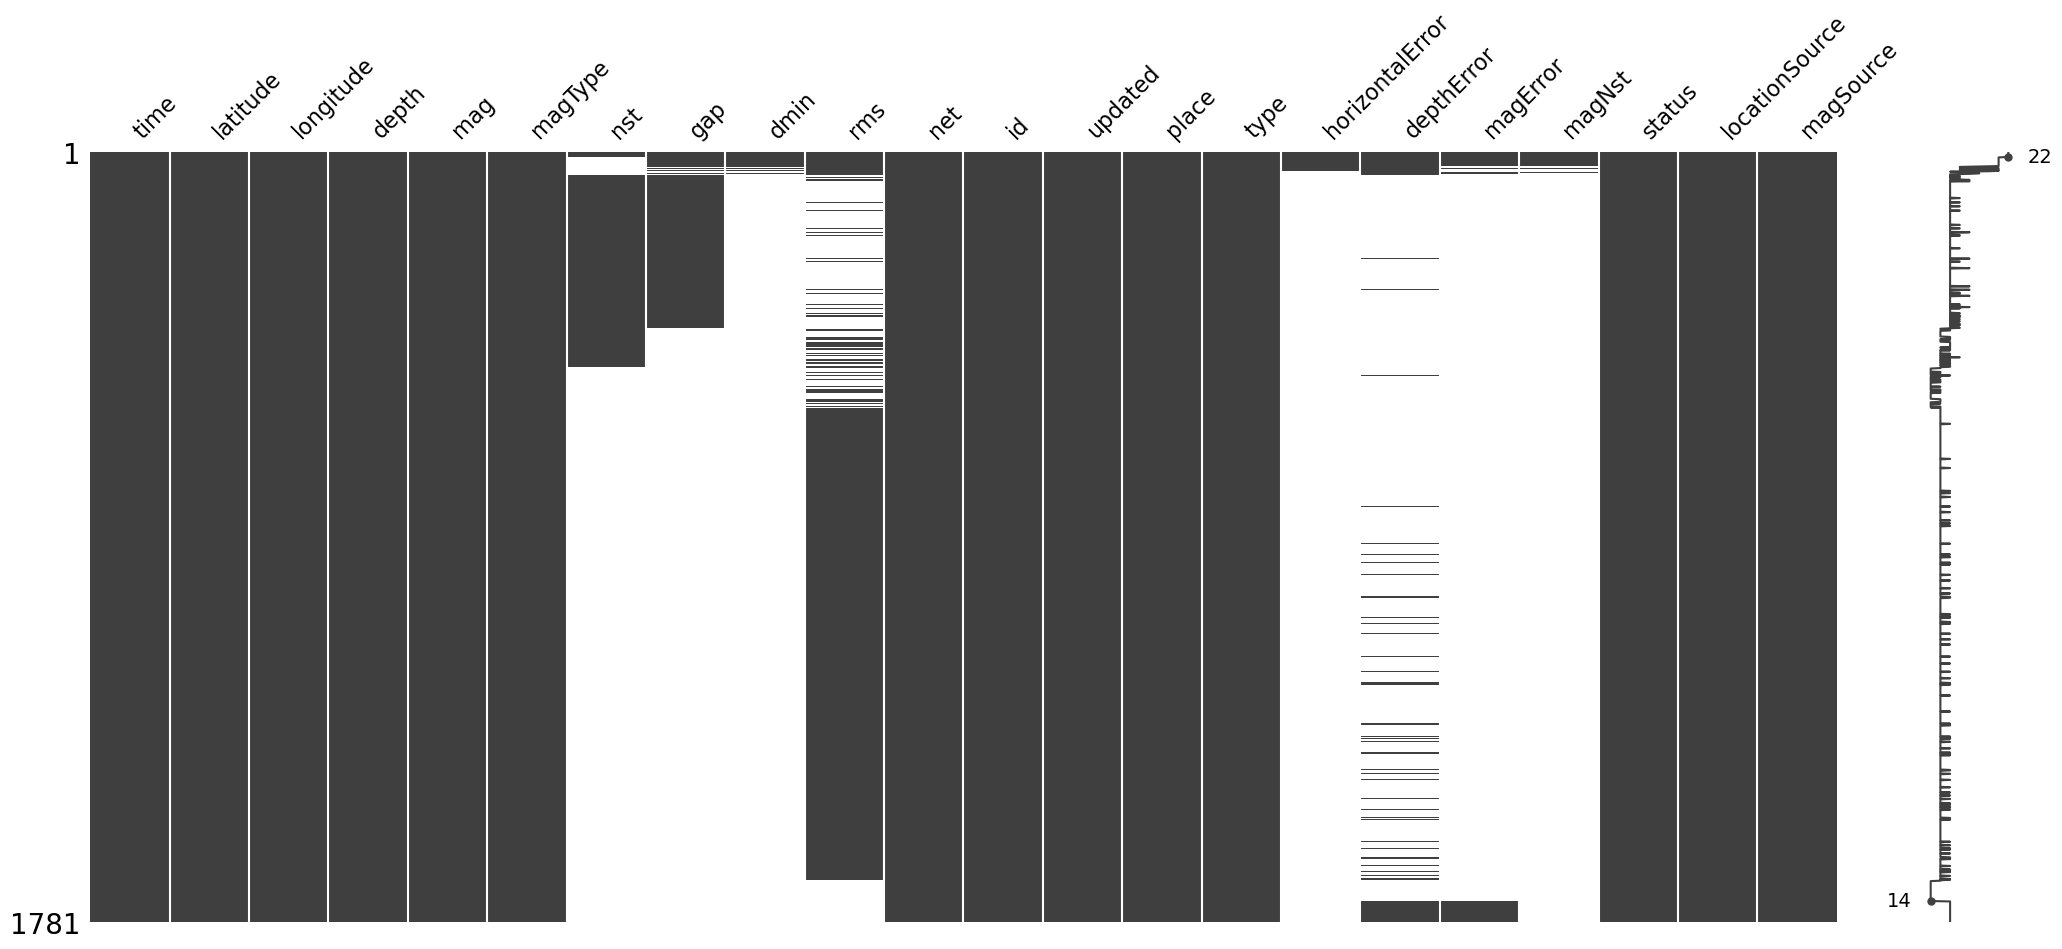

In [20]:
msn.matrix(df)

In [21]:
drop_columns = ["nst", "gap", "dmin", "rms", "horizontalError", "depthError", "magError", "magNst"]
df.drop(columns = drop_columns, inplace = True)

In [22]:
reference_cities = {
    "Skopje": (41.9981, 21.4254),
    "Belgrade": (44.7866, 20.4489),
    "Tirana": (41.3275, 19.8189),
    "Thessaloniki": (40.6401, 22.9444),
    "Podgorica": (42.4304, 19.2594),
    "Zagreb": (45.8150, 15.9819)
}

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    
    a = np.sin(dphi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return R * c

ml_to_mw = { 
    "Skopje": lambda ml: 0.912 + 0.880 * ml, 
    "Belgrade": lambda ml: 0.324 + 0.963 * ml, 
    "Tirana": lambda ml: 1.624 + 0.743 * ml,  
    "Thessaloniki": lambda ml: 0.383 + 1.010 * ml,  
    "Podgorica": lambda ml: 0.218 + 0.985 * ml,
    "Zagreb": lambda ml: 0.165 + 0.979 * ml
}


def find_nearest_city(lat, lon):
    distances = {city: haversine(lat, lon, *coords) for city, coords in reference_cities.items()}
    return min(distances, key=distances.get)


ml_df = df[df['magType'].str.lower() == 'ml'].copy()

ml_df['nearest_city'] = ml_df.apply(lambda row: find_nearest_city(row['latitude'], row['longitude']), axis=1)

In [23]:
ml_df['mw_converted'] = ml_df.apply(
    lambda row: ml_to_mw[row['nearest_city']](row['mag']),
    axis=1
)

In [26]:
ml_mags = ml_df[ml_df['magType'].str.lower() == 'ml']['mw_converted'].values


other_magtypes = ['mw', 'mwr', 'mww', 'mwc']
other_mags = df[df['magType'].str.lower().isin(other_magtypes)]['mag'].values


magnitudes = np.concatenate([ml_mags, other_mags]) 

### *EDA and Visualization*

##### *General histogram of earthquake magnitudes*

<Axes: ylabel='Count'>

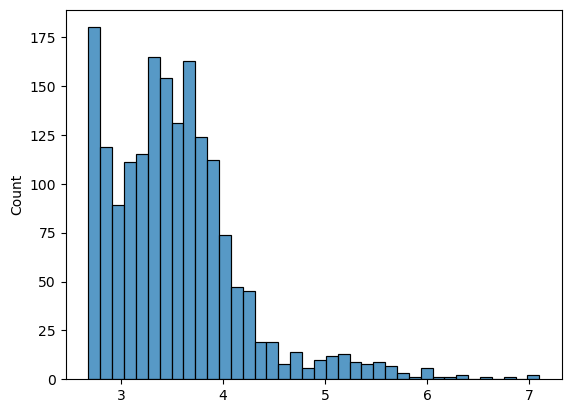

In [28]:
#magnitudes = ["mag"] 
sns.histplot(magnitudes) 

##### *Empirical Gutenberg-Richter plot*

In [29]:
bins = [i for i in range(2,8)]  

min_val = magnitudes.min()

M_vals = np.linspace(start=min_val, stop=7, num=1000)
M_indices = [i for i in range(len(M_vals))]
counts = [0] * len(M_indices)

j=0 
for M in M_vals:
    for magnitude in magnitudes:
        if magnitude >= M: 
            counts[j] += 1 
    j+=1   


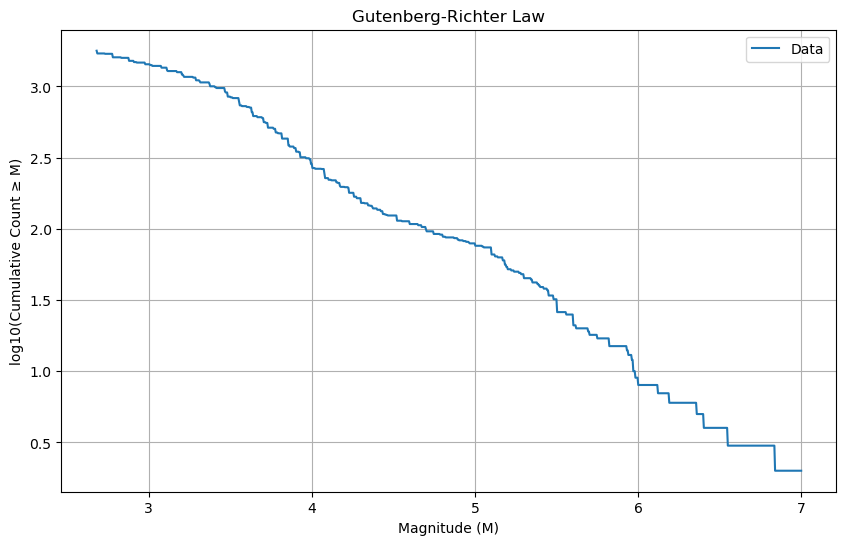

In [30]:
plt.figure(figsize=(10,6))
plt.plot(M_vals, np.log10(counts), label='Data')
plt.xlabel('Magnitude (M)')
plt.ylabel('log10(Cumulative Count ≥ M)')
plt.title('Gutenberg-Richter Law')
plt.grid(True)
plt.legend()
plt.show()

#### *Survival function (CCDF)*

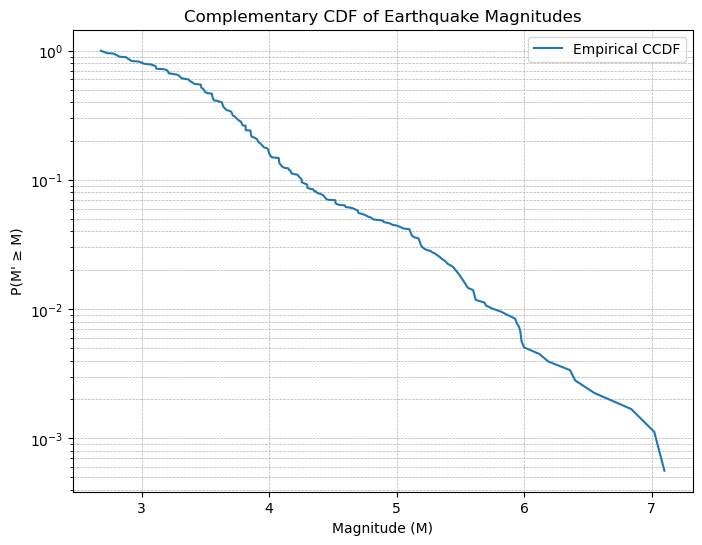

In [31]:
import numpy as np
import matplotlib.pyplot as plt

magnitudes = np.sort(magnitudes)

ccdf = np.array([np.sum(magnitudes >= m) / len(magnitudes) for m in magnitudes])

plt.figure(figsize=(8, 6))
plt.plot(magnitudes, ccdf, linestyle="solid", label='Empirical CCDF')
plt.yscale('log')  
plt.xlabel("Magnitude (M)")
plt.ylabel("P(M' ≥ M)")
plt.title("Complementary CDF of Earthquake Magnitudes")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

### *Statistical Modeling: estimating the b-value in the formula*

##### *Aki's MLE estimator* 
 
 Aki's classic estimator [2] models earthquake magnitudes as a continuous random variable following an exponential distribuiton. The above histogram of the frequencies of earthquakes by magnitudes certainly justifies this assumtion for our data. This approach also assumes a *completenes threshold* - a minimum earthquake magnitude above which we believe all earthquakes are recorded reliably. In this project, we will assume this value is 2.5. Firstly, let us acknowledge that:  

 $\log_{10} N = a - bM $   
 $N = 10^{a - bM} = 10^a \cdot 10^{-bM}$  
 $N \propto 10^{-bM}$

 In order to model earthquake magintudes as exponentially distributed random variables, we will need to convert to an expression in base-$e$, so we have  

 $$10^{-bM} = e^{-bM\cdot \ln(10)}, \text{ and for convenience we will define } \beta = b \cdot \ln(10) $$  

Let $M \geq M_{min}$ be the magnitude. We assume the magnitudes follow: 

$$f(M;\beta) = \beta e^{-\beta(M-M_{min})}$$  


Given n independent observations $M_1, M_2, ..., M_n$, the likelihood is:  

$$L(\beta) = \prod_{i=1}^{n} \beta e^{{-\beta(M_i-M_{min})}} = \beta^n e ^{ - \beta \sum_{i=1}^{n}(M_i - M_{min})}$$  

Taking the log of the likelihood function gives us: 

$$\log L(\beta) = n \log \beta - \beta \sum_{i=1}^{n} (M_i - M_{min})$$  

Taking the derivative of the log-likelihood with respect to $\beta$:  

$$\frac{d}{d\beta} \log L(B) = \frac{n}{\beta} - \sum_{i=1}^{n} (M_i - M_{min}) $$  

Setting the derivative equal to zero, and solving for $\hat{\beta}$  

$$\frac{n}{\hat{\beta}} = \sum_{i=1}^{n}$$  
$$\hat{\beta} = \frac{n}{\sum_{i=1}^{n}(M_i - M_{min})}$$  

We can substitute the denominator with $n \cdot (\overline{M} - M_{min})$, and we finally get 


$$\beta = \frac{1}{\overline{M} - M_{min}}$$  

Recall that $\beta = b \cdot \ln (10) $, so our final estimate for $b$ becomes:  

$$\hat{b} = \frac{1}{\ln(10)\cdot(\overline{M} - M_{min})} $$





In [32]:
import numpy as np

M_min = min_val
M = magnitudes[magnitudes >= M_min]

mean_mag = np.mean(M)
b_mle = 1 / (np.log(10) * (mean_mag - M_min))
print(f"MLE estimate of b: {b_mle:.4f}")

MLE estimate of b: 0.5033


Comparing the fitted exponential PDF to the histogram of our data.

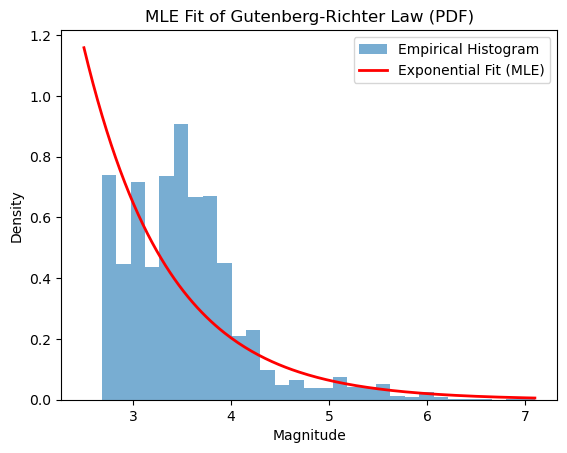

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon

Mmin = 2.5
beta_mle = b_mle * np.log(10)


plt.hist(magnitudes, bins=30, density=True, alpha=0.6, label="Empirical Histogram")

x = np.linspace(Mmin, magnitudes.max(), 200)
pdf = beta_mle * np.exp(-beta_mle * (x - Mmin))
plt.plot(x, pdf, 'r-', lw=2, label=f"Exponential Fit (MLE)")

plt.xlabel("Magnitude")
plt.ylabel("Density")
plt.title("MLE Fit of Gutenberg-Richter Law (PDF)")
plt.legend()
plt.show()


Comparing the CCDF of our data vs with our fitted b value.

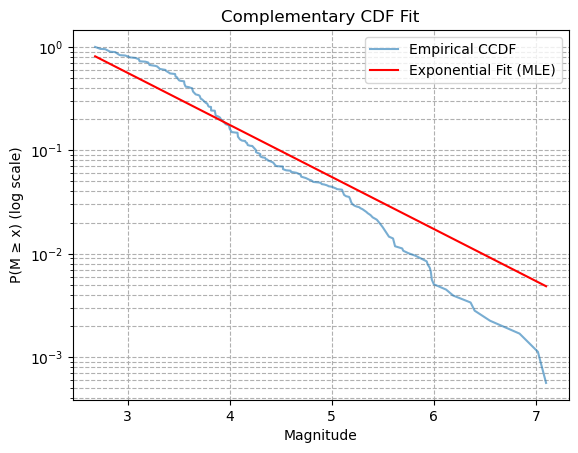

In [34]:
sorted_mags = np.sort(magnitudes)
ccdf_empirical = np.array([np.sum(magnitudes >= m) / len(magnitudes) for m in magnitudes])
ccdf_theoretical = np.exp(-beta_mle * (sorted_mags - Mmin))

plt.plot(sorted_mags, ccdf_empirical, label="Empirical CCDF",  linestyle='solid', alpha=0.6)
plt.plot(sorted_mags, ccdf_theoretical, label="Exponential Fit (MLE)", color='r')

plt.yscale('log')
plt.xlabel("Magnitude")
plt.ylabel("P(M ≥ x) (log scale)")
plt.title("Complementary CDF Fit")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


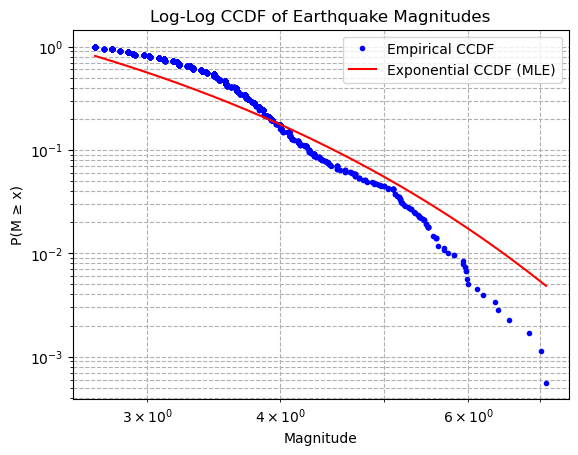

In [35]:
plt.loglog(sorted_mags, ccdf_empirical, 'b.', label="Empirical CCDF")
plt.loglog(sorted_mags, ccdf_theoretical, 'r-', label="Exponential CCDF (MLE)")
plt.xlabel("Magnitude")
plt.ylabel("P(M ≥ x)")
plt.title("Log-Log CCDF of Earthquake Magnitudes")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

While the exponential model provides a theoretically justified fit (per the Gutenberg–Richter law), the Kolmogorov–Smirnov test revealed significant deviation between the observed and predicted distributions (K–S statistic = 0.0951, p-value ≈ 0), suggesting that the model may not fully capture the statistical properties of the dataset.

In [36]:
from scipy.stats import kstest

D, p_value = kstest(magnitudes, lambda x: expon.cdf(x, loc=Mmin, scale=1/beta_mle))
print(f"K-S Statistic: {D:.4f}, p-value: {p_value:.4f}")

K-S Statistic: 0.2683, p-value: 0.0000


##### *Bayesial approach* 
Yaghmaei-Sabegh et al. [3] propose a Bayesian approach to estimating the b-parameter. We will retain our exponential assumption when deriving the likelihood function for the data, but we will introduce a Gamma prior for our $\beta$ parameter. Note: due to the ambiguity of the $\beta$ parameter analyised in the context of the Gutenberg-Richter law and the one used as a parameter in the gamma distribution in most literature, this text will use unconventional notation - denoting $\alpha$ and $\beta$ of the gamma distribution as $k$ and $\lambda$, respectivelly.  

First, for our beta prior we have  


$$p(\beta) = \frac{\lambda^k}{\Gamma(k)} \beta^{k-1} e^{-\lambda \beta}$$  

Using the same likelihood function as before, we can derive the posterior as follows: 



$$
p(\beta \mid \bold{m}) \propto p(\bold{m} \mid \beta) p(\beta)$$     
$$\propto \underbrace{\beta^n e^{-\beta S}}_{Likelihood} \cdot \underbrace{\beta^{k-1} e^{-\lambda \beta}}_{Prior}$$ 
$$\propto \beta^{n + k - 1} e^{-\beta (S + \lambda)},$$ 



where $\bold{m}$ is our data and  $S = \sum_{i=1}^{n}(M_{i} - M_{min} )$. Note that this is a gamma distribution given with  

$$\beta \mid \bold{m} \sim \Gamma(k + n, \lambda + S)$$  


Then $b$ is recovered by:  

$$b = \frac{\beta}{ln(10)}$$

Posterior shape (k): 1791.000
Posterior rate (lambda): 1865.602
Posterior mean of beta: 0.96001
Posterior mean of b-value: 0.41693


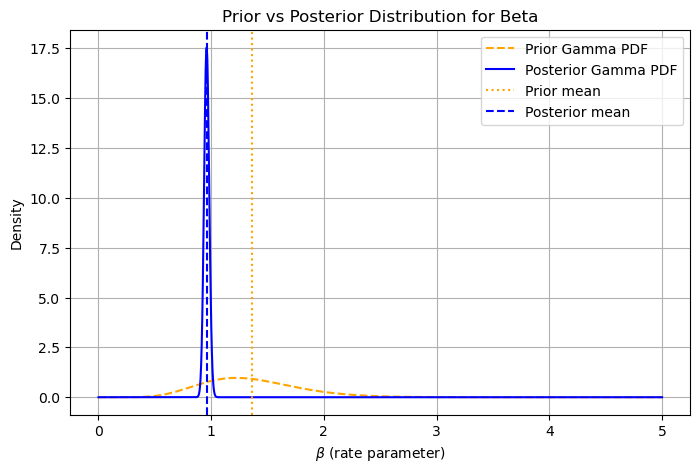

In [37]:
import numpy as np
from scipy.stats import gamma

M = magnitudes  
Mmin = 2.5         

X = M - Mmin
X = X[X > 0]  
n = len(X)
S = X.sum()

b_mle = 0.59 # use Aki's estimate to choose priors
beta_mle = b_mle * np.log(10)  # ~1.3595

k_prior = 10
lambda_prior = k_prior / beta_mle


k_post = k_prior + n
lambda_post = lambda_prior + S

beta_post_mean = k_post / lambda_post

b_post_mean = beta_post_mean / np.log(10)

print(f"Posterior shape (k): {k_post:.3f}")
print(f"Posterior rate (lambda): {lambda_post:.3f}")
print(f"Posterior mean of beta: {beta_post_mean:.5f}")
print(f"Posterior mean of b-value: {b_post_mean:.5f}")

# Beta values range for smooth plot
beta_vals = np.linspace(0, 5, 1000)

# Calculate PDFs
prior_pdf = gamma.pdf(beta_vals, a=k_prior, scale=1/lambda_prior)
posterior_pdf = gamma.pdf(beta_vals, a=k_post, scale=1/lambda_post)

# Plot
plt.figure(figsize=(8,5))
plt.plot(beta_vals, prior_pdf, label='Prior Gamma PDF', linestyle='--', color='orange')
plt.plot(beta_vals, posterior_pdf, label='Posterior Gamma PDF', color='blue')
plt.axvline(k_prior / lambda_prior, color='orange', linestyle=':', label='Prior mean')
plt.axvline(k_post / lambda_post, color='blue', linestyle='--', label='Posterior mean')
plt.xlabel(r'$\beta$ (rate parameter)')
plt.ylabel('Density')
plt.title('Prior vs Posterior Distribution for Beta')
plt.legend()
plt.grid(True)
plt.show()

The posterior mean is 0.54, which differs from the previous estimate, but not siginificantly, let us inspect the the histogram-to-fit, CCDF and log-log plots. 

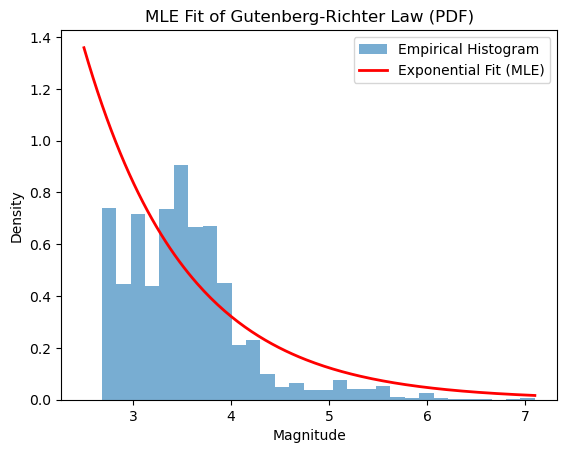

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon

Mmin = 2.5


plt.hist(magnitudes, bins=30, density=True, alpha=0.6, label="Empirical Histogram")

x = np.linspace(Mmin, magnitudes.max(), 200)
pdf = beta_mle * np.exp(-beta_post_mean * (x - Mmin))
plt.plot(x, pdf, 'r-', lw=2, label=f"Exponential Fit (MLE)")

plt.xlabel("Magnitude")
plt.ylabel("Density")
plt.title("MLE Fit of Gutenberg-Richter Law (PDF)")
plt.legend()
plt.show()

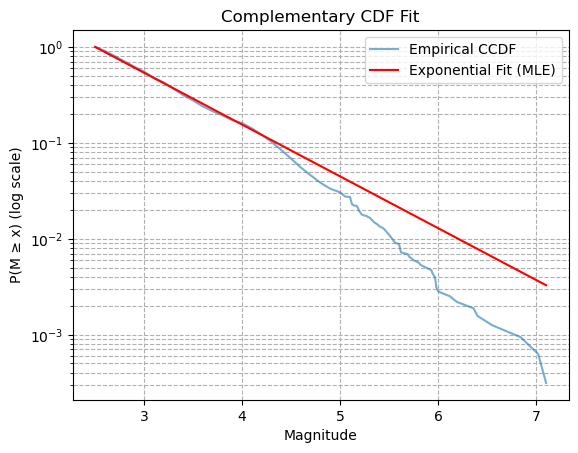

In [20]:
sorted_mags = np.sort(magnitudes)
ccdf_empirical = np.array([np.sum(magnitudes >= m) / len(magnitudes) for m in magnitudes])
ccdf_theoretical = np.exp(-beta_post_mean * (sorted_mags - Mmin))

plt.plot(sorted_mags, ccdf_empirical, label="Empirical CCDF",  linestyle='solid', alpha=0.6)
plt.plot(sorted_mags, ccdf_theoretical, label="Exponential Fit (MLE)", color='r')

plt.yscale('log')
plt.xlabel("Magnitude")
plt.ylabel("P(M ≥ x) (log scale)")
plt.title("Complementary CDF Fit")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

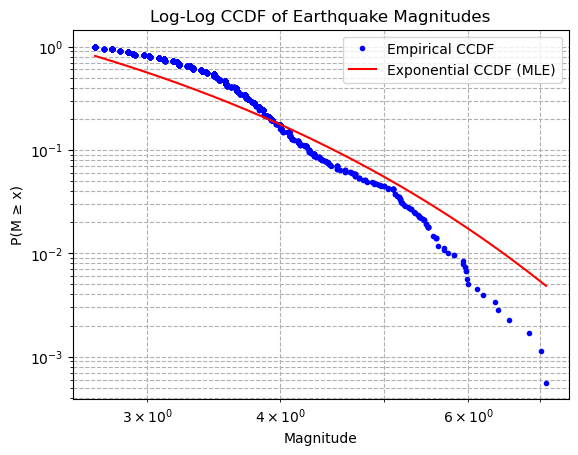

In [39]:
plt.loglog(sorted_mags, ccdf_empirical, 'b.', label="Empirical CCDF")
plt.loglog(sorted_mags, ccdf_theoretical, 'r-', label="Exponential CCDF (MLE)")
plt.xlabel("Magnitude")
plt.ylabel("P(M ≥ x)")
plt.title("Log-Log CCDF of Earthquake Magnitudes")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

The fit seems to be slighly better, at least during the first half of the graph. Still, it seems unlikely that a KS test will lead to accepting the hypothesis of our data following the calculated distribution.

In [40]:
from scipy.stats import kstest

D, p_value = kstest(magnitudes, lambda x: expon.cdf(x, loc=Mmin, scale=1/beta_post_mean))
print(f"K-S Statistic: {D:.4f}, p-value: {p_value:.4f}")

K-S Statistic: 0.2061, p-value: 0.0000


In fact, the K-S statistic remains the same, i.e the greatest gap between the two distributions is just as large as the previously fitted one. 

#### *Extreme Value Theory Analysis*

In this part of the project, we will analyize the tails of earthquake distributions.
 

We will perform the same preprocessing steps on the data, except we will use data gathered from Japan. 

<Axes: xlabel='mag', ylabel='Count'>

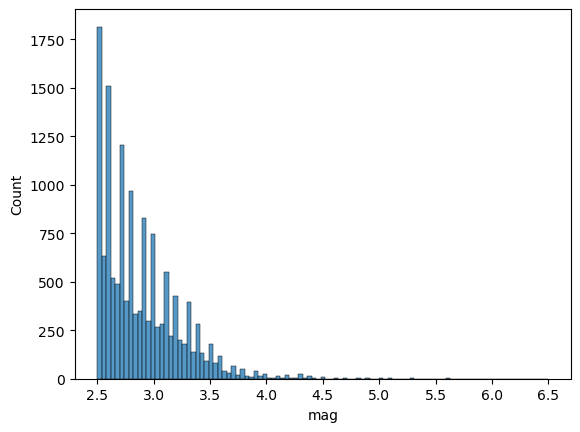

In [ ]:
df = pd.read_csv("data/california.csv")
df.sample(3)

df["time"] = pd.to_datetime(df["time"]) # Transform time column to hold Pandas DateTime objects 
df.drop_duplicates(inplace=True)

drop_columns = ["nst", "gap", "dmin", "rms", "horizontalError", "depthError", "magError", "magNst"]
df.drop(columns = drop_columns, inplace = True)

magnitudes = df["mag"].where(df["magType"]=='ml') 

sns.histplot(magnitudes) 

In [9]:
df["magType"].value_counts()

magType
ml     14059
md      2988
mw       936
mb       271
mlr      264
mwr      218
mww       62
mh        36
mc         3
mwc        1
Name: count, dtype: int64

 As evident in the histogram, Japan (unfortunatelly) experiences a high frequency of high-magnitude earthquakes, making the data suitable candidate for EVT analysis.

##### *General extreme value (GEV) distribution* 

The Generalized Extreme Value (GEV) [4] distribution is a fundamental model in Extreme Value Theory (EVT) used to describe the behavior of the maximum (or minimum) values drawn from a large collection of independent and identically distributed (i.i.d.) random variables.

The GEV distribution unifies three types of extreme value distributions into one family:  

$$G(z) = \exp{\{-[1+\xi(\frac{z-\mu}{\sigma})]^{\frac{-1}{\xi}}\}}$$  


$\mu$: Roughly, the typical value of the maximum magnitude in a block (e.g., average yearly maximum magnitude).

$\sigma$: How much variability there is in those maxima.

Shape $\xi$: Determines the tail behavior:

$\xi>0$ (Fréchet): Heavy tail, higher chance of extremely large earthquakes beyond observed max.

$\xi=0$ (Gumbel): Light tail, exponential decay, extreme values thin out quickly.

$\xi<0$ (Weibull): Bounded tail, theoretical maximum earthquake magnitude.

We will attempt to capture the probabilistic behavior of the largest earthquakes in Japan from 2015 to 2025. We will divide the data into one-month long blocks and sample the maximum earthquake magnitude in each month.  

GEV shape: -0.059, location: 5.643, scale: 0.430


/tmp/ipykernel_152574/55370554.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['time'].dt.to_period('M')


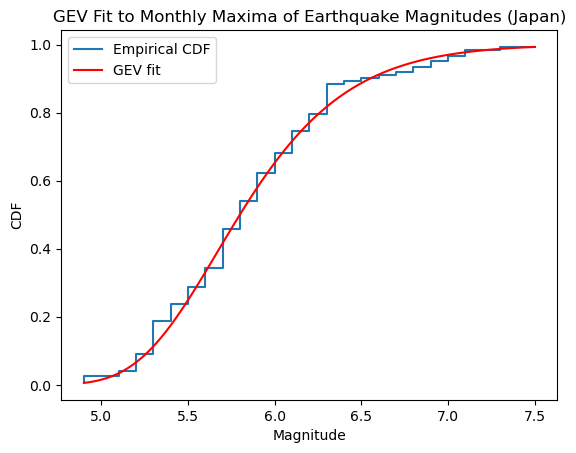

In [33]:
from scipy.stats import genextreme

magnitudes = df['mag']
times = df['time']

df['month'] = df['time'].dt.to_period('M')
monthly_max = df.groupby('month')['mag'].max()
params = genextreme.fit(monthly_max)
c, loc, scale = params
print(f"GEV shape: {-c:.3f}, location: {loc:.3f}, scale: {scale:.3f}")

x = np.linspace(min(monthly_max), max(monthly_max), 100)
cdf_empirical = np.arange(1, len(monthly_max)+1) / (len(monthly_max)+1)
cdf_fitted = genextreme.cdf(x, c, loc=loc, scale=scale)

plt.step(np.sort(monthly_max), cdf_empirical, label='Empirical CDF')
plt.plot(x, cdf_fitted, label='GEV fit', color='red')
plt.xlabel("Magnitude")
plt.ylabel("CDF")
plt.legend()
plt.title("GEV Fit to Monthly Maxima of Earthquake Magnitudes (Japan)")
plt.show()

In [ ]:
mu = np.mean(monthly_max)
sigma = np.var(monthly_max)


5.868595041322314

#### *References*
[1] - Gutenberg, B., and C. F. Richter (1944). Frequency of earthquakes in
California, Bull. Seismol. Soc. Am. 34  
[2] - Aki, K. (1965). Maximum likelihood estimate of b in the formula log N =
a - bM and its confidence limits, Bull. Earthq. Res. Inst. Tokyo Univ.
43  
[3] - Yaghmaei-Sabegh, S., Ostadi-Asl, G. Bayesian estimation of b-value in Gutenberg–Richter relationship: a sample size reduction approach. Nat Hazards 110, 1783–1797 (2022). https://doi.org/10.1007/s11069-021-05012-0  
[4] - Stuart Coles. An introduction to statistical modeling of extreme values. Springer Series in Statistics. Springer, London, England, 2001 edition, August 2001. ISBN 978-1-85233-459-8. URL: https://doi.org/10.1007/978-1-4471-3675-0.  
[5] - Acta Geod. Geoph. Hung., Vol. 45(3), pp. 317–323 (2010) DOI: 10.1556/AGeod.45.2010.3.6 